# 0 Configuration

In [37]:
config = {
    "feature_eng": {

    },
    "modeling": {
        "dummy": False,
        "linear_reg": False,
        "svr": False,
        "tree": False,
        "forest": False,
        "xgboost": False
    }
}

***
# 1 Dependency import

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import set_config

import xgboost
from xgboost import XGBRegressor

import shap

# plt.style.use(["dark_background"])
plt.style.use(["default"])
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(0)

In [39]:
def get_categorical_features_name(dataset, split_by_unique_count=True, split_count=10):
    features_name = dataset.select_dtypes(["object", "bool"]).columns
    if split_by_unique_count:
        less_uniques = [feature_name for feature_name in features_name if dataset[feature_name].nunique() <= split_count]
        lot_uniques = features_name.difference(less_uniques).tolist()
        return (less_uniques, lot_uniques)
    else:
        return features_name.values

In [40]:
def get_numerical_features_name(dataset):
    features_name = dataset.select_dtypes(["int64", "float64"]).columns.values.tolist()
    return features_name

In [41]:
def evaluate(model, grid_params, dataset, target, scoring="neg_root_mean_squared_error"):
    set_config(display="diagram") # display="text" -> for textual output

    ### DATASET PREPARATION ###

    y = dataset[target].copy()
    X = dataset.drop(columns=[target]).copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

    categorical_cols_less_unique, categorical_cols_lot_unique = get_categorical_features_name(X_train)
    numerical_cols = get_numerical_features_name(X_train)

    ### PIPELINE CONSTRUCTION ###

    num_pipe = Pipeline(steps=[
        ("simple_imputer", SimpleImputer(strategy="mean"))
    ])

    cat_less_unique_pipe = Pipeline(steps=[
        ("simple_imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    cat_lot_unique_pipe = Pipeline(steps=[
        ("simple_imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num_pipe", num_pipe, numerical_cols),
        ("cat_less_unique_pipe", cat_less_unique_pipe, categorical_cols_less_unique),
        ("cat_lot_unique_pipe", cat_lot_unique_pipe, categorical_cols_lot_unique)
    ])

    pipeline = Pipeline([
        ("transforms", preprocessor),
        ("model", model)
    ])

    ### GRIDSEARCH DECLARATION AND FITTING ###

    gs = GridSearchCV(pipeline, grid_params, scoring=scoring, refit=True)
    gs.fit(X_train, y_train)

    ### MOST COMMONLY USED METRICS CALCULATION ###

    score = gs.score(X_test, y_test)
    ratio = (score * 100) / y_test.mean()
    ratio = np.abs(ratio)
    target = y_test

    ### FEATURE IMPORTANCE OUTPUT ###
    best_model = gs.best_estimator_.named_steps["model"]
    categorical_cols_less_unique = gs.best_estimator_["transforms"].transformers_[1][1]["one_hot_encoder"].get_feature_names_out(categorical_cols_less_unique).tolist()
    categorical_cols_lot_unique = gs.best_estimator_["transforms"].transformers_[2][1]["one_hot_encoder"].get_feature_names_out(categorical_cols_lot_unique).tolist()
    feature_names = numerical_cols + categorical_cols_less_unique + categorical_cols_lot_unique

    return score, ratio, target, gs, best_model, feature_names, X_train, y_train, X_test, y_test

In [42]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [43]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

***
# 2 Loading data

In [44]:
data = pd.read_csv("data/data-cleaned.csv", delimiter=",")

In [45]:
data.drop(columns=["Unnamed: 0"], inplace=True)

In [46]:
target_1 = "SiteEnergyUse(kBtu)"
target_2 = "GHGEmissionsIntensity(kgCO2e/ft2)"

In [47]:
# y = data[target]
# X = data.drop(columns=[target])

In [48]:
# X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

In [49]:
# categorical_cols_less_unique = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and X_train_full[cname].dtype == "object"]
# categorical_cols_lot_unique = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() >= 10 and X_train_full[cname].dtype == "object"]
# numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

In [50]:
# my_cols = categorical_cols_lot_unique + categorical_cols_less_unique + numerical_cols
# X_train = X_train_full[my_cols].copy()
# X_test = X_test_full[my_cols].copy()

In [51]:
# y_test.describe()

***
# 3 Feature engineering

## 3.1 Mutual Information

In [52]:
# X_MI = X.copy()

In [53]:
# X_MI["DefaultData"] = X_MI["DefaultData"].astype("object")

In [54]:
# X_MI_NUM = X_MI.select_dtypes(["int64", "float64"]).columns
# X_MI_CAT = X_MI.select_dtypes(["object"]).columns

In [55]:
# discrete_features = X_MI.dtypes == object

In [56]:
# impt_num = SimpleImputer(strategy="mean")
# X_MI[X_MI_NUM] = pd.DataFrame(impt_num.fit_transform(X_MI[X_MI_NUM]))

In [57]:
# impt_cat = SimpleImputer(strategy="most_frequent")
# X_MI[X_MI_CAT] = pd.DataFrame(impt_cat.fit_transform(X_MI[X_MI_CAT]))

In [58]:
# for col in X_MI_CAT:
#     X_MI[col], _ = X_MI[col].factorize()

In [59]:
# scores = make_mi_scores(X_MI, y, discrete_features).sort_values(ascending=False)
# scores.head()

In [60]:
# def plot_mi_scores(scores):
#     plt.figure(dpi=100, figsize=(8, 5))
#     scores = scores.sort_values(ascending=True)
#     width = np.arange(len(scores))
#     ticks = list(scores.index)
#     plt.barh(width, scores)
#     plt.yticks(width, ticks)
#     plt.title("Mutual Information Scores")

# plot_mi_scores(scores)

***
# 4 Modeling

***
## 4.1 DummyRegressor

In [61]:
%%time
if config["modeling"]["dummy"]:

    model = DummyRegressor()

    grid_params = [
        {
            "model__strategy": ["mean", "median"]
        },
        {
            "model__strategy": ["quantile"],
            "model__quantile": np.arange(0, 1.1, 0.1),
        }
    ]

    score, ratio, gs, pipeline = evaluate(model, grid_params)

    print(f"RMSE: {score:n} / RATIO: {ratio:.4}%")
    print(f"best_params: {gs.best_params_}")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


***
## 4.2 LinearRegression

In [62]:
%%time
if config["modeling"]["linear_reg"]:

    model = LinearRegression()

    grid_params = [
        {
            "model__fit_intercept": [True]
        }
    ]

    score, ratio, gs, pipeline = evaluate(model, grid_params)

    print(f"RMSE: {score:n} / RATIO: {ratio:.4}%")
    print(f"best_params: {gs.best_params_}")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


***
## 4.3 SupportVectorRegression

In [63]:
%%time
if config["modeling"]["svr"]:

    model = SVR()

    grid_params = [
        {
            "model__kernel": ["rbf"],
            "model__degree": [3],
            "model__gamma": ["scale"]
        }
    ]

    score, ratio, gs, pipeline = evaluate(model, grid_params)

    print(f"RMSE: {score:n} / RATIO: {ratio:.4}%")
    print(f"best_params: {gs.best_params_}")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


***
## 4.4 DecisionTreeRegressor

In [64]:
%%time
if config["modeling"]["tree"]:

    model = DecisionTreeRegressor()

    grid_params = [
        {
            "model__random_state": [1],
            "model__max_depth": [2, 3, 4],
            "model__min_samples_leaf": range(1, 11, 1),
            "model__criterion": ["mse"]
        }
    ]

    score, ratio, gs, pipeline = evaluate(model, grid_params)

    print(f"RMSE: {score:n} / RATIO: {ratio:.4}%")
    print(f"best_params: {gs.best_params_}")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.48 µs


***
## 4.5 RandomForestRegressor

In [65]:
%%time
if config["modeling"]["forest"]:

    model = RandomForestRegressor()

    grid_params = [
        {
            "model__random_state": [1],
            "model__n_estimators": [25],
            "model__min_samples_leaf": [1],
            "model__criterion": ["mse"]
        }
    ]

    score, ratio, gs, pipeline = evaluate(model, grid_params)

    print(f"RMSE: {score:n} / RATIO: {ratio:.4}%")
    print(f"best_params: {gs.best_params_}")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


***
## 4.6 XGBRegressor

In [66]:
%%time
if config["modeling"]["xgboost"]:

    model = XGBRegressor()

    grid_params = [
        {
            "model__random_state": [1],
            "model__max_depth": [3],
            "model__n_estimators": [100],
            "model__learning_rate": [0.1],
        }
    ]

    score, ratio, pipeline, gs, X_train, y_train, X_test, y_test, categorical_cols_less_unique, categorical_cols_lot_unique = evaluate(model, grid_params, data, target_1)

    print(f"RMSE: {-score:.4}")
    print(f"Target mean value: {y_train.mean():.4}")
    print(f"Ratio: {ratio:.4}%")
    print(f"best_params: {gs.best_params_}")

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10.7 µs


***
## 4.7 Permutation, PDP, SHAP

In [67]:
model = XGBRegressor()

grid_params = [
    {
        "model__random_state": [1],
        "model__max_depth": [3],
        "model__n_estimators": [100],
        "model__learning_rate": [0.1],
    }
]

score, ratio, target, gs, best_model, feature_names = evaluate(model, grid_params, data, target_1)

print(f"RMSE: {-score:.4}")
print(f"Target mean value: {target.mean():.4}")
print(f"Ratio: {ratio:.4}%")
print(f"best_params: {gs.best_params_}")

RMSE: 0.1439
Target mean value: 0.5656
Ratio: 25.43%
best_params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__random_state': 1}


***
### 4.6.3 Feature explainability

In [68]:
X_train_preproc = pd.DataFrame(data=gs.best_estimator_.named_steps["transforms"].fit_transform(X_train, y_train).toarray(), columns=feature_names)
X_test_preproc = pd.DataFrame(data=gs.best_estimator_.named_steps["transforms"].transform(X_test).toarray(), columns=feature_names)

,OSEBuildingID,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SteamUse(kBtu),Electricity(kWh),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingType_campus,BuildingType_multifamily hr (10+),BuildingType_multifamily lr (1-4),BuildingType_multifamily mr (5-9),BuildingType_nonresidential,BuildingType_nonresidential cos,BuildingType_sps-district k-12,DefaultData_False,DefaultData_True,ComplianceStatus_compliant,ComplianceStatus_error - correct default data,ComplianceStatus_missing data,ComplianceStatus_non-compliant,Address_(id23682) 3204 sw morgan st,Address_10 harrison st.,Address_100 4th ave n,Address_100 6th ave s,Address_100 aloha st,Address_100 crockett st.,Address_100 melrose ave e,Address_100 n 85th st,Address_100 ne northlake way,Address_100 nw 85th street,Address_100 roy st,Address_100 south king street,Address_100 taylor avenue n,Address_100 ward street,Address_100 west harrison,Address_100 west highland drive,Address_100 west roy st,Address_1000 1st ave w,Address_1000 1st ave.,Address_1000 4th ave s,Address_1000 8th ave,Address_1000 aurora ave n,Address_1000 denny way,Address_1000 e pike st,Address_1000 fairview ave n,Address_1000 fourth avenue,Address_1000 lenora st.,Address_1000 minor ave,Address_1000 ne 88th st,Address_1000 north northlake way,Address_1000 occidental ave.,Address_1000 s weller st,Address_1000 second avenue,Address_1000 seneca st,Address_1000 union st,Address_10001 57th ave. s,Address_10006 aurora ave n,Address_1001 alaskan way,Address_1001 fairview ave n,Address_1001 fourth avenue,Address_1001 lenora st.,Address_1001 queen anne ave n,Address_1001 s myrtle st,Address_10015 lake city way ne,Address_1002 airport way s,Address_10020 martin luther king jr way s,Address_1004 belmont ave e,Address_1004 boren ave,Address_1005 6th avenue s,Address_1005 e roy st,Address_1005 harbor ave sw,Address_1005 spring street,Address_1005 terrace st,Address_1006 spring st,Address_1007 first ave.,Address_1008 western ave,Address_1009 ne pacific st,Address_101 - 110 16th ave,Address_101 n 104th st 98133,Address_101 n 46th st,Address_101 nickerson st,Address_101 prefontaine pl s,Address_101 s. dakota,Address_101 stewart street,Address_101 taylor ave n,Address_101 w. lee st.,Address_101 west olympic place,Address_101 yesler way,Address_1010 8th ave s,Address_1011 5th avenue n,Address_1011 east terrace street,Address_1011 pike st,Address_1011 western ave,Address_10115 greenwood ave n.,Address_1012 s.w. trenton st.,Address_1014 1st ave s,Address_1014 first avenue,Address_1015 & 1017 olive way,Address_1015 queen anne ave n.,Address_1015 second avenue,Address_1017 boren avenue,Address_1017 e harrison st,Address_1017 minor ave,Address_1017 w nickerson st,Address_1018 1st ave,Address_1019 harbor avenue sw,Address_1019 terry ave,Address_102 n 132nd st,Address_1020 1st ave s,Address_1020 5th ave n,Address_1020 john st.,Address_1020 ne 50th ave,Address_1020 ne 63rd st.,Address_1020 seneca st,Address_1020 university st,Address_10203 47th ave sw,Address_10215 greenwood ave. n,Address_10215 lake city way ne,Address_1024-1048 6th ave s,Address_1026 ne 65th st,Address_1027 bellevue ct e,Address_1029 summit ave e,Address_103 13th ave e,Address_103 1st ave,Address_103 bellevue ave e,Address_103 vine st,Address_10301 greenwood ave n,Address_10303 meridian ave n,Address_10306 meridian avenue north,Address_1032 s. jackson,Address_10321 merdian ave north,Address_10330 meridian ave n,Address_10345 meridian ave n,Address_104 pine st,Address_104 twelfth avenue,Address_1040 s henderson,Address_10404 34th ave sw,Address_10416 5th avenue ne,Address_1046 1st ave s,Address_105 14th avenue,Address_105 5th ave s,Address_105 harvard ave e,Address_105 mercer st,Address_105

In [70]:
explainer = shap.TreeExplainer(best_model, data=X_train_preproc)
# shap_values = explainer(X_train_preproc)
shap_values = explainer(X_train_preproc)

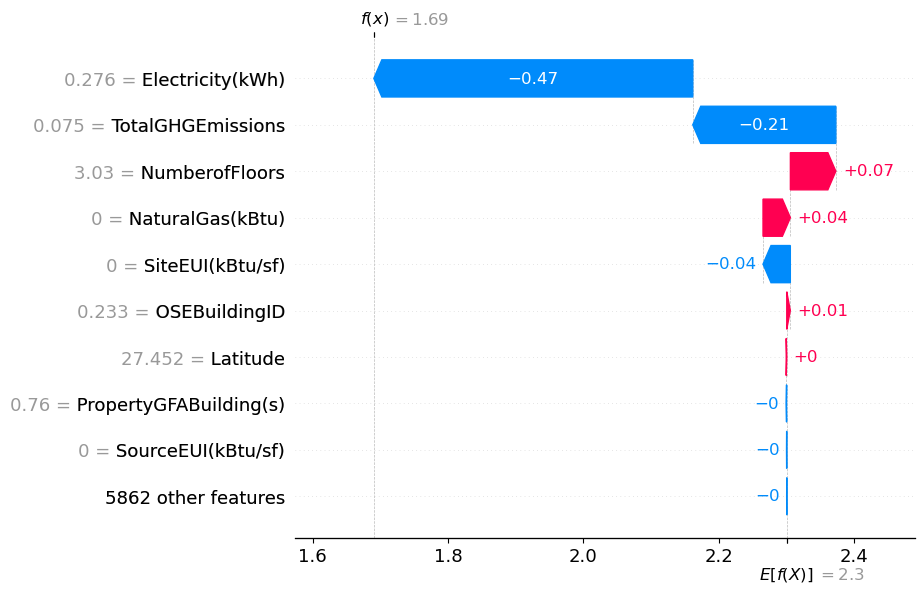

In [89]:
shap.plots.waterfall(shap_values[0])

In [88]:
shap.plots.force(shap_values[0])

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values.values) # takes too much time

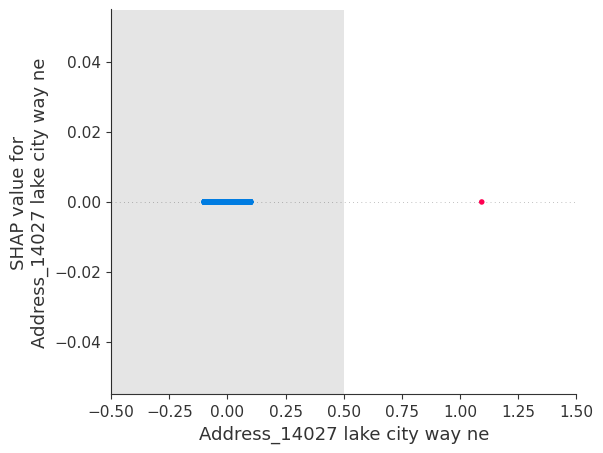

In [85]:
shap.plots.scatter(shap_values[:,"Address_14027 lake city way ne"], color=shap_values)

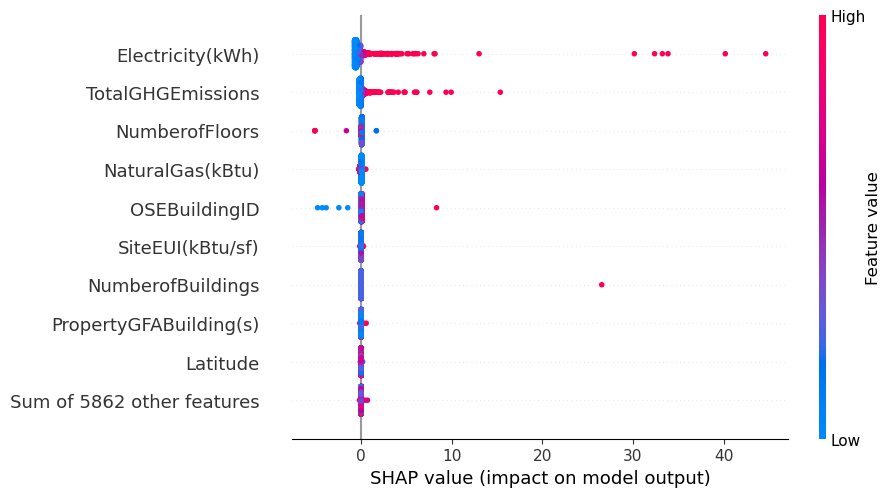

In [86]:
shap.plots.beeswarm(shap_values)

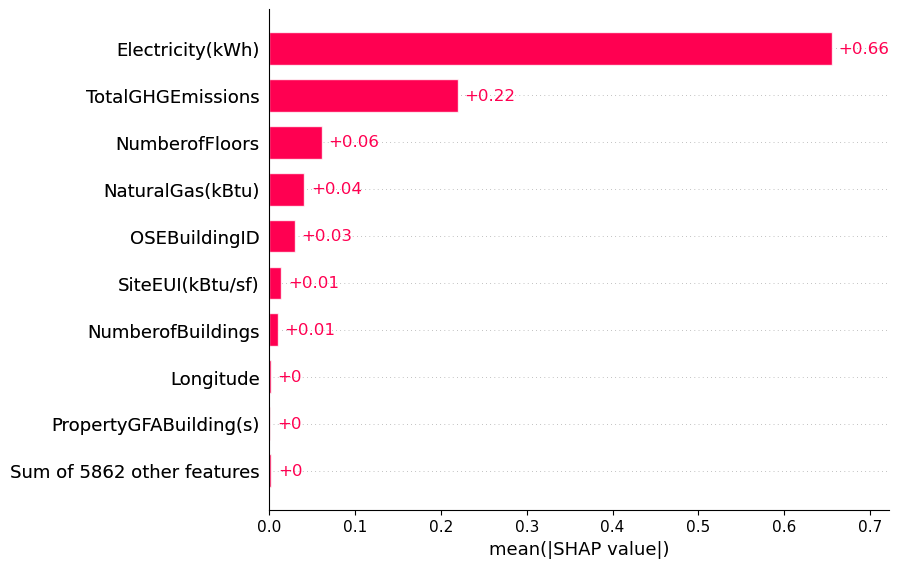

In [87]:
shap.plots.bar(shap_values)

***
# 5 ...

...

***
# 6 ...

transformer la cible avec log -> cela donne des résultats aberrants  
analyser les résultats des modèles (xgboost): quel sont les points faibles ? quelles sont les features les plus parlantes ? ---> feature engineering
...